In [1]:
import sklearn
import matplotlib.pyplot as plt
from training.sigopt_utils import build_sigopt_name
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import random
from pymatgen.core import Structure
from inference.select_best_models import get_experiment_id


/home/jypeng/miniconda3/envs/Perovskite_ML_Environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

path = "inference/James_Scrap/"

with open(path+'entropy_dft_held_out.json', 'r') as fp:
    formula_to_entropy_dft = json.load(fp)
    
with open(path+'entropy_CGCNN_held_out.json', 'r') as fp:
    formula_to_entropy_CGCNN = json.load(fp)
    
with open(path+'entropy_e3nn_held_out.json', 'r') as fp:
    formula_to_entropy_e3nn = json.load(fp)
    
with open(path+'Prs_dft_held_out.json', 'r') as fp:
    formula_to_Prs_dft = json.load(fp)
    
with open(path+'Prs_CGCNN_held_out.json', 'r') as fp:
    formula_to_Prs_CGCNN = json.load(fp)
    
with open(path+'Prs_e3nn_held_out.json', 'r') as fp:
    formula_to_Prs_e3nn = json.load(fp)

In [3]:
def check_if_rocksalt(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if abs(dist-4.0)<0.1 and struct.species[j]==struct.species[i]:
                    return False
                
    return True

def get_is_rocksalt(df):
    is_rocksalt = []
    
    for i in range(len(df)):
        is_rocksalt.append(check_if_rocksalt(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_rocksalt


def check_if_layered(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
                        
            if count_NN != 2 or count_Next_NN != 1:
                return False
                
    return True

def get_is_layered(df):
    is_layered = []
    
    for i in range(len(df)):
        is_layered.append(check_if_layered(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_layered


def check_if_column(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
    
            if count_NN != 1 or count_Next_NN != 1:
                return False
                
    return True

def get_is_column(df):
    is_col = []
    
    for i in range(len(df)):
        is_col.append(check_if_column(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_col

In [4]:
def get_np_embedding(df):
    curr_embeddings = df["embedding_0"]
    
    arr_list = []
    for embedding in curr_embeddings:
        arr_list.append(np.asarray(embedding[0]))
    np_embedding = np.asarray(arr_list)
    
    return np_embedding

In [5]:
def get_rs_vec(embeddings,pca):
    
    rs_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_rocksalt:
                rs_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = rs_pos - ref/5.0
        
        rs_vec.append(curr_dist)
        
        
    rs_vec = np.asarray(rs_vec)
    return rs_vec
    
    
def get_layered_vec(embeddings,pca):
    lay_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_layered"] = get_is_layered(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_layered:
                lay_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = lay_pos - ref/5.0
        
        lay_vec.append(curr_dist)
        
        
    lay_vec = np.asarray(lay_vec)
    return lay_vec

def get_col_vec(embeddings,pca):
    col_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_column"] = get_is_column(embeddings)
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        #print(curr_embeddings.is_column)
        
        #ref = projection.mean(axis=0)
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_column:
                col_pos = projection[i,:]
            else:
                ref += projection[i,:]
            
        curr_dist = col_pos - ref/5.0
        
        col_vec.append(curr_dist)
        
        
    col_vec = np.asarray(col_vec)
    return col_vec
    

In [6]:
sorted_forms = sorted(formula_to_entropy_dft.items(), key=lambda x: x[1])

In [7]:
sorted_forms

[('Ba8Ir4La4O24', 0.16315121970519145),
 ('La4O24Sb4Sr8', 0.1631512200446522),
 ('Ba8La4O24Ru4', 0.16315122213919167),
 ('Mg4O24Re4Sr8', 0.16315123460583358),
 ('Mn4O24Sr8Te4', 0.16315130747742254),
 ('Ba8Ni4O24U4', 0.1631513084529657),
 ('Ba8Ir4O24Sc4', 0.16315143675637425),
 ('O24Ru4Sr8Y4', 0.16315160897152056),
 ('Ba8Mn4O24Re4', 0.16315337381566294),
 ('Ba8O24Re4Y4', 0.16315342868211105),
 ('Ir4O24Sr8Zn4', 0.1631566021780588),
 ('Ni4O24Sr8U4', 0.1631596395838352),
 ('Ba8Co4Mo4O24', 0.16316101791393767),
 ('Ir4O24Sc4Sr8', 0.1631645008660468),
 ('Mo4O24Sr8Zn4', 0.16317199295590715),
 ('Ca8O24Ta4Y4', 0.16320073719281863),
 ('Mn4O24Sr8U4', 0.16320967526502825),
 ('O24Sr8U4Zn4', 0.1632290321875449),
 ('O24Sb4Sc4Sr8', 0.1633228536822596),
 ('Cu4O24Os4Sr8', 0.16475635090708696),
 ('La8Ni4O24Pt4', 0.1656202492643266),
 ('Nb4O24Sr8Y4', 0.16610290961698948),
 ('Fe4O24Sr8Ta4', 0.16614977890621746),
 ('Ba8Fe4O24Ta4', 0.16675934197534598),
 ('Co4Nd8O24Pt4', 0.1669735439277663),
 ('Mn4Ni4O24Tb8',

In [22]:

from matplotlib.patches import FancyArrowPatch

def embeddings_from_file(model_params,test):
    target_prop = "dft_e_hull"
    
    idx = 0
    exp_id = get_experiment_id(model_params, "dft_e_hull")
    sigopt_name = build_sigopt_name(model_params["data"], target_prop, model_params["struct_type"], model_params["interpolation"], model_params["model_type"],contrastive_weight=model_params["contrastive_weight"],training_fraction=model_params["training_fraction"],long_range=False)
    directory = "./best_models/" + param["model_type"] + "/" + sigopt_name + "/" +str(exp_id) + "/" + "best_" + str(idx)
    
    data = pd.read_json(directory + '/' + test + "_embeddings"+"_"+str(0)+".json")
    return data




def get_pca(param,test,num_comps=5,star_rocksalt=True,square_layered=True,rs_heatmap=True):
    
    if test == "holdout_set_B_sites":
        rs_heatmap=False
    embeddings = embeddings_from_file(param,test)
    np_embedding = get_np_embedding(embeddings)
    
    pca = PCA(n_components=2)
    pca.fit(np_embedding)
    projection = pca.transform(np_embedding)
    
    random.seed(0)
    selected_forms = random.sample(list(embeddings["formula"]), num_comps)
    #sorted_forms = sorted(formula_to_entropy_dft.items(), key=lambda x: x[1])
    #selected_forms = [sorted_forms[20][0],sorted_forms[40][0],sorted_forms[60][0],sorted_forms[80][0],sorted_forms[99][0]]

    #print(selected_forms)
    
    selected_colors = []
    projection_featured = []
    projection_rs_ordering = []
    projection_lay_ordering = []
    projection_col_ordering = []
    
    for i in range(len(selected_forms)):
        curr_form = selected_forms[i]
        
        
        filtered_embeddings = embeddings[embeddings["formula"]==curr_form]
        filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
        filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
        filtered_embeddings["is_column"] = get_is_column(filtered_embeddings)
        
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        curr_rs_ordering = list(filtered_embeddings["is_rocksalt"])
        curr_lay_ordering = list(filtered_embeddings["is_layered"])
        curr_col_ordering = list(filtered_embeddings["is_column"])
        
        projection_featured.append(curr_projection)
        projection_rs_ordering.append(curr_rs_ordering)
        projection_lay_ordering.append(curr_lay_ordering)
        projection_col_ordering.append(curr_col_ordering)
        
        min_val = 0.163151599
        range_vals = 1.0 - 0.163151599
        
        #curr_color = np.ones(curr_projection.shape[0])*(formula_to_entropy_dft[curr_form]-min_val)/range_vals
        curr_color = np.ones(curr_projection.shape[0])*i
        selected_colors.append(curr_color)
        
    print(selected_colors)
    dft_entropy = []
    pca_spread = []
    
    for form in set(embeddings["formula"]):
        dft_entropy.append(formula_to_entropy_dft[form])
        
        filtered_embeddings = embeddings[embeddings["formula"]==form]
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        mean_pos = curr_projection.mean(axis=0)
        
        tmp_pca_vals = []
        
        for k in range(len(curr_projection)):
            tmp_pca_vals.append(np.sqrt(np.sum((curr_projection[k,:]-mean_pos)**2)))
            
        pca_spread.append(np.asarray(tmp_pca_vals).mean())
        
    
    background_embeddings = embeddings[~embeddings["formula"].isin(selected_forms)]
    np_background_embeddings = get_np_embedding(background_embeddings)
    projection_background = pca.transform(np_background_embeddings)
    
    if not rs_heatmap:
        plt.scatter(projection_background[:,0],projection_background[:,1],c="black",alpha=0.03)
        for i in range(len(projection_featured)):
            has_found = False
            if star_rocksalt and square_layered:
                for j in range(len(projection_featured[i][:,0])):
                    if not projection_rs_ordering[i][j] and not projection_lay_ordering[i][j] and not has_found:
                        curr_label = selected_forms[i]
                        has_found = True
                    else:
                        curr_label = None
                    if projection_rs_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='*',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")
                    elif projection_lay_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='s',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")
                    #elif projection_col_ordering[i][j]:
                    #    plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='P',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8)
                    else:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],s=40,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8,edgecolors= "black")

            else:
                plt.scatter(projection_featured[i][:,0],projection_featured[i][:,1],c=selected_colors[i],label=selected_forms[i],vmin=0.0,vmax=num_comps,alpha=0.8)
                
                
        size = (projection[:,0].max()-projection[:,0].min())*0.04
        
        x_pos = projection[:,0].max() - projection[:,0].min()
        
        y_pos = projection[:,1].max() - projection[:,1].min()
        
        if param["model_type"] == "CGCNN":
        
            a = 1
    
        else:
            
            net_rs = get_rs_vec(embeddings,pca).mean(axis=0)

            net_layered = get_layered_vec(embeddings,pca).mean(axis=0)
            
            x_start = x_pos*0.70 + projection[:,0].min()
            y_start = y_pos*0.45+projection[:,1].min()
            dx = net_rs[0]
            dy = net_rs[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            x_start = x_pos*0.15 + projection[:,0].min()
            y_start = y_pos*0.15 +projection[:,1].min()
            dx = net_layered[0]
            dy = net_layered[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            
        plt.gca().set_box_aspect(1)
        
        plt.xlabel("PCA Component 1",size = 15)
        plt.ylabel("PCA Component 2",size = 15)
        plt.legend(bbox_to_anchor=(1.02, 1))
        plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.savefig("figures/embedding_"+param["model_type"]+".pdf",bbox_inches="tight")
        plt.show()

        

    if rs_heatmap:
        embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
        np_embedding = get_np_embedding(embeddings)
        projection = pca.transform(np_embedding)
        class_labels = []
        for i in range(len(embeddings)):
            if embeddings.iloc[i].is_rocksalt:
                class_labels.append(1)
            else:
                class_labels.append(0)
        class_labels = np.asarray(class_labels)
        
        x = projection[:,0]
        y = projection[:,1]
        
        bins_x = np.linspace(min(x), max(x), num=25)
        bins_y = np.linspace(min(y), max(y), num=25)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=(bins_x, bins_y))

        class_probabilities = np.zeros((len(bins_x) - 1, len(bins_y) - 1))

        for i in range(len(bins_x) - 1):
            for j in range(len(bins_y) - 1):
                mask = (x >= bins_x[i]) & (x < bins_x[i + 1]) & (y >= bins_y[j]) & (y < bins_y[j + 1])
                if np.sum(mask) > 0:
                    bin_class_prob = np.mean(class_labels[mask])
                    class_probabilities[i, j] = bin_class_prob
                else:
                    # If there are no data points in this bin, set the class probability to NaN
                    class_probabilities[i, j] = np.nan

        # Create the heatmap plot based on class probabilities with a single colormap
        cmap = plt.get_cmap('viridis')
        cmap.set_bad(color='white')  # Set color for bins with no data to white

        plt.imshow(class_probabilities.T, extent=(bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]), origin='lower', cmap=cmap, vmin=0, vmax=0.8)
        plt.colorbar(label='Class Probability')
        plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)

        plt.show()
        
        np_embedding_filt = get_np_embedding(embeddings[embeddings["is_rocksalt"]==True])
        projection_filt = pca.transform(np_embedding_filt)
        plt.scatter(projection[:,0],projection[:,1],alpha=0.2)
        plt.scatter(projection_filt[:,0],projection_filt[:,1],alpha=0.2)
        
        print(projection_filt.shape[0]/projection.shape[0])
        plt.show()

    
    return dft_entropy, pca_spread
    
    

In [23]:
all_params = [
{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "CGCNN",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
    

{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "e3nn",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
]

all_tests = ["holdout_set_B_sites"]

dft_e_hull_htvs_data_unrelaxed_CGCNN


/tmp/ipykernel_4042638/162220076.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/162220076.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/162220076.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

[array([0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2.]), array([3., 3., 3., 3., 3., 3.]), array([4., 4., 4., 4., 4., 4.])]


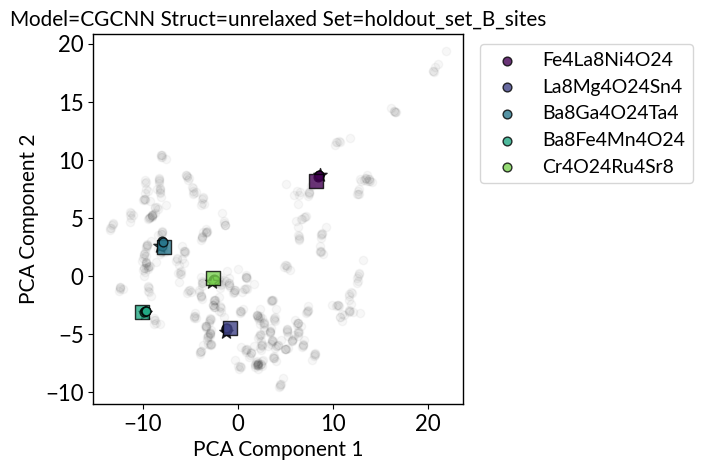

dft_e_hull_htvs_data_unrelaxed_e3nn


/tmp/ipykernel_4042638/162220076.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/162220076.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/162220076.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

[array([0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2.]), array([3., 3., 3., 3., 3., 3.]), array([4., 4., 4., 4., 4., 4.])]


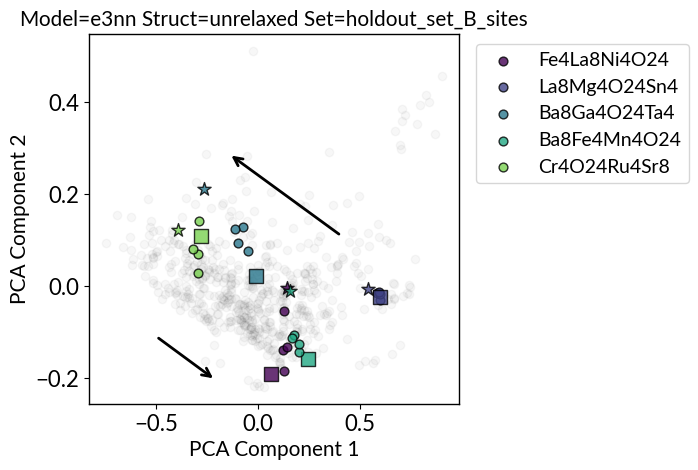

In [24]:
for param in all_params:
    for test in all_tests:
        get_pca(param,test)

In [11]:
for param in all_params:
    for test in all_tests:
        print(param)
        print(test)

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}
holdout_set_B_sites
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'e3nn', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}
holdout_set_B_sites


In [12]:
print(all_params[0])

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}


In [13]:
print(all_tests[0])

holdout_set_B_sites


In [14]:
param = all_params[0]
test = all_tests[0]

dft_e_hull_htvs_data_unrelaxed_CGCNN
['La8Ni4O24Pt4', 'Ba8Nb4O24Sc4', 'Cu4Nd8O24Sn4', 'Cu4La8O24Rh4', 'Mn4O24Pr8Rh4']


/tmp/ipykernel_4042638/4134344485.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

[array([0.00294994, 0.00294994, 0.00294994, 0.00294994, 0.00294994,
       0.00294994]), array([0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528]), array([0.30928851, 0.30928851, 0.30928851, 0.30928851, 0.30928851,
       0.30928851]), array([0.81522083, 0.81522083, 0.81522083, 0.81522083, 0.81522083,
       0.81522083]), array([0.96527991, 0.96527991, 0.96527991, 0.96527991, 0.96527991,
       0.96527991])]


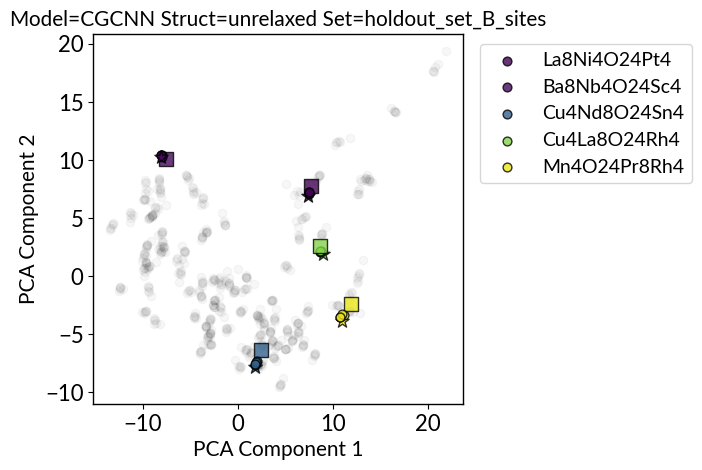

([0.9491603519673195,
  0.7223813961301209,
  0.16315337381566294,
  0.8690689645311952,
  0.18037820231160717,
  0.8648873975006715,
  0.16316101791393767,
  0.16702490223507227,
  0.1815330082259183,
  0.16675934197534598,
  0.7933926411460162,
  0.35410326085572813,
  0.96423348371594,
  0.2714611788382856,
  0.3301990232849606,
  0.1631596395838352,
  0.21889185457814006,
  0.8627237032118008,
  0.3333123100585972,
  0.9111377754744461,
  0.17113231363588222,
  0.7961521080795847,
  0.27450259669779636,
  0.17903405234413922,
  0.778451092141434,
  0.1734518828020697,
  0.17154120956915053,
  0.788963922565016,
  0.7677957250309655,
  0.16315160897152056,
  0.16315122213919167,
  0.18503752800969347,
  0.1916413675226691,
  0.16315130747742254,
  0.8473074537612363,
  0.16320967526502825,
  0.3007861978772566,
  0.16787107309682264,
  0.8715125953569075,
  0.18155202528964995,
  0.1631513084529657,
  0.42249429329768223,
  0.5921675570706704,
  0.1633228536822596,
  0.8453678501729

In [15]:
get_pca(param,test)

dft_e_hull_htvs_data_unrelaxed_CGCNN
['La8Ni4O24Pt4', 'Ba8Nb4O24Sc4', 'Cu4Nd8O24Sn4', 'Cu4La8O24Rh4', 'Mn4O24Pr8Rh4']


/tmp/ipykernel_4042638/4134344485.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

[array([0.00294994, 0.00294994, 0.00294994, 0.00294994, 0.00294994,
       0.00294994]), array([0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528]), array([0.30928851, 0.30928851, 0.30928851, 0.30928851, 0.30928851,
       0.30928851]), array([0.81522083, 0.81522083, 0.81522083, 0.81522083, 0.81522083,
       0.81522083]), array([0.96527991, 0.96527991, 0.96527991, 0.96527991, 0.96527991,
       0.96527991])]


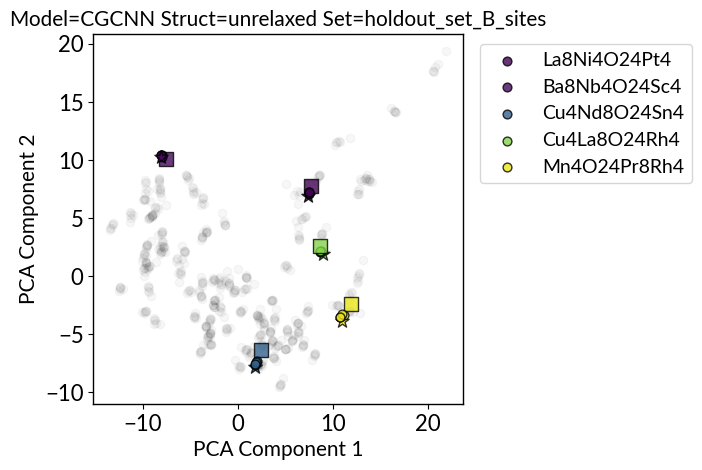

dft_e_hull_htvs_data_unrelaxed_e3nn
['La8Ni4O24Pt4', 'Ba8Nb4O24Sc4', 'Cu4Nd8O24Sn4', 'Cu4La8O24Rh4', 'Mn4O24Pr8Rh4']


/tmp/ipykernel_4042638/4134344485.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

[array([0.00294994, 0.00294994, 0.00294994, 0.00294994, 0.00294994,
       0.00294994]), array([0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528]), array([0.30928851, 0.30928851, 0.30928851, 0.30928851, 0.30928851,
       0.30928851]), array([0.81522083, 0.81522083, 0.81522083, 0.81522083, 0.81522083,
       0.81522083]), array([0.96527991, 0.96527991, 0.96527991, 0.96527991, 0.96527991,
       0.96527991])]


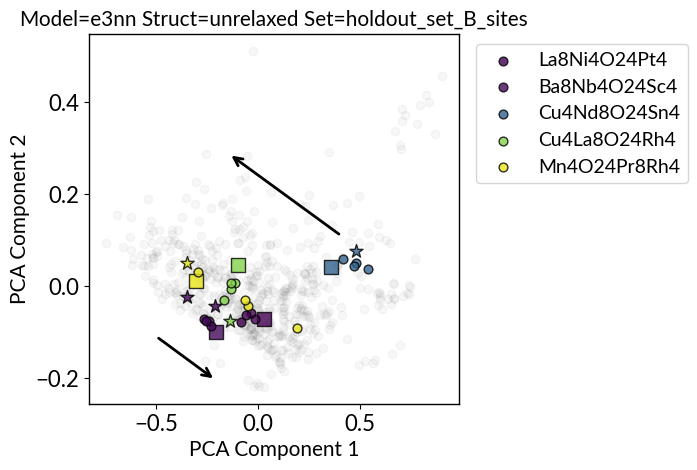

In [16]:
param = all_params[0]
test = all_tests[0]
dft_entropy, pca_CGCNN = get_pca(param,test)
param = all_params[1]
test = all_tests[0]
dft_entropy, pca_e3nn = get_pca(param,test)

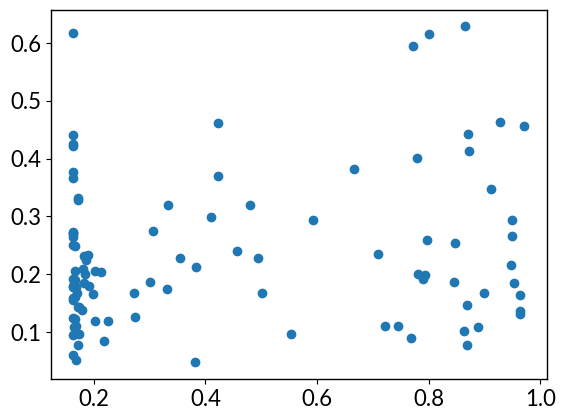

In [17]:
plt.scatter(dft_entropy,pca_CGCNN)

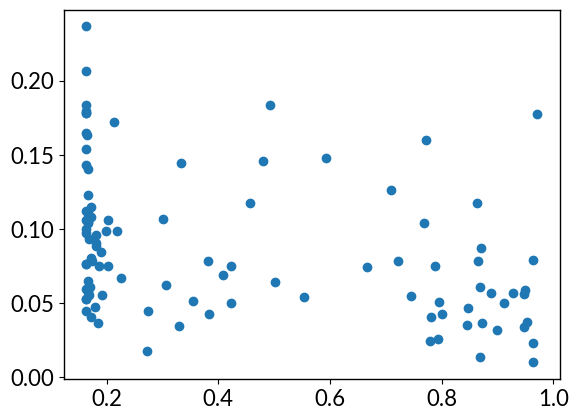

In [18]:
plt.scatter(dft_entropy,pca_e3nn)

In [19]:
def get_partitions(entropy,dist):
    
    small = []
    medium = []
    large = []
    
    for i in range(len(entropy)):
        if entropy[i]<0.25:
            small.append(dist[i])
        elif entropy[i]>0.75:
            large.append(dist[i])
        else:
            medium.append(dist[i])
    
    print(np.asarray(small).mean())
    print(np.asarray(medium).mean())
    print(np.asarray(large).mean())

In [20]:
get_partitions(dft_entropy,pca_CGCNN)

0.20756023724108516
0.22972423636820097
0.27622528939886076


In [21]:
get_partitions(dft_entropy,pca_e3nn)

0.10342036354601747
0.08289473416742271
0.05970362544556133


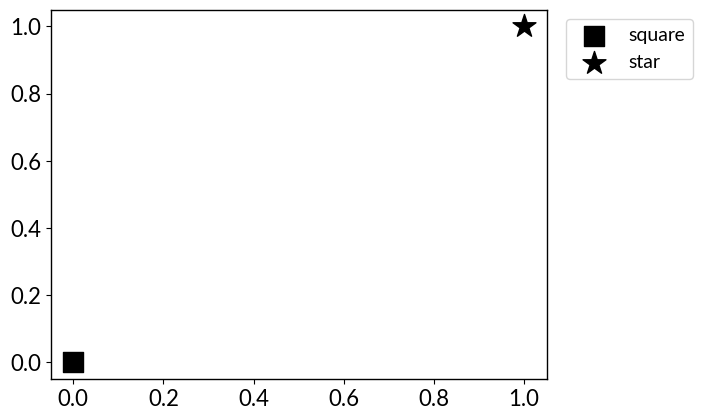

In [63]:
plt.scatter(0,0,marker="s",color="black",label="square",s = 200)
plt.scatter(1,1,marker="*",color="black",label="star",s=300)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.savefig("figures/Star_ref.pdf",bbox_inches="tight")
plt.show()